In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools
from qulacs import DensityMatrix
from qulacs.state import partial_trace, tensor_product
from qulacs.gate import H, CNOT, Probabilistic,  DepolarizingNoise, DenseMatrix
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf

In [2]:
def generate_pauli_matrix(pauli_str):
    pauli_dict = {
        "I": np.array([[1, 0], [0, 1]], dtype=complex),
        "X": np.array([[0, 1], [1, 0]], dtype=complex),
        "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
        "Z": np.array([[1, 0], [0, -1]], dtype=complex)
    }
    matrix = np.array([1], dtype=complex)
    for p in pauli_str:
        matrix = np.kron(matrix, pauli_dict[p])
    return matrix

def create_global_depolarizing_noise_gate(k, epsilon):
    
    target_qubits = list(range(k))
    
    pauli_labels = ["I", "X", "Y", "Z"]
    
    identity_key = tuple("I" for _ in range(k))
    gate_prob_dict = { identity_key: 1 - epsilon + epsilon / (4**k) }
    
    
    for comb in itertools.product(pauli_labels, repeat=k):
        if comb == identity_key:
            continue
        gate_prob_dict[comb] = epsilon / (4**k)
    
    
    gate_list = []
    prob_list = []
    for pauli_tuple, prob in gate_prob_dict.items():
        
        pauli_str = list(pauli_tuple)
        matrix = generate_pauli_matrix(pauli_str)
        
        gate = DenseMatrix(target_qubits, matrix)
        gate_list.append(gate)
        prob_list.append(prob)
    

    noise_gate = Probabilistic(prob_list, gate_list)
    return noise_gate

In [3]:
def exact_time_evolution(rho_input, n_qubit, theta):
    rho = rho_input.copy()
    
    #define constants
    basis = "sto-3g"  #basis set
    multiplicity = 1  #spin multiplicity
    charge = 0        #total charge for the molecule
    distance = 1.1
    geometry = [("H",(0,0,0)),("H", (0,0,distance))]  #xyz coordinates for atoms
    description = str(distance)  #description for the psi4 output file

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    jw_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))
    hamiltonian_matrix = get_sparse_operator(jw_hamiltonian).toarray()
    U_mat = scipy.linalg.expm(1j * theta / 2 * hamiltonian_matrix)
    exp_H = DenseMatrix([i for i in range(n_qubit)], U_mat)
    exp_H.update_quantum_state(rho)
    
    return rho

def noisy_time_evolution(rho_input, n_qubit, layer, theta, p_err):
    rho = rho_input.copy()
    for l in range(layer):
        rho = exact_time_evolution(rho, n_qubit, theta)
    
    noise_gate = create_global_depolarizing_noise_gate(n_qubit, p_err*layer*n_qubit)
    noise_gate.update_quantum_state(rho)

    return rho

def symmetric_channel_verification_U1(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, noise = True, with_ancilla_noise = False):
    layer_per_purification = layer // verification_frequensy
    p_err_gadget = 0
    if noise:
        p_err_gadget = p_err
    n_ancilla = int(np.ceil(np.log2(n_qubit+1)))
    rho = rho_input.copy()

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_ancilla)
        rho = tensor_product(rho_ancilla, rho)

        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
            
        for n1 in range(n_ancilla):
            H(n_qubit+n1).update_quantum_state(rho)
            for n2 in range(n_qubit):
                Phase_gate = DenseMatrix(n2, [[1 , 0], [0, np.exp(1j*2*np.pi/2**n_ancilla * 2**n1)]])
                Phase_gate.add_control_qubit(n_qubit+n1, 1)
                Phase_gate.update_quantum_state(rho)

        # U
        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n+n_qubit, p_err*layer).update_quantum_state(rho)

        # U_D
        for n1 in range(n_ancilla):
            for n2 in range(n_qubit):
                Phase_gate = DenseMatrix(n2, [[1 , 0], [0, np.exp(-1j*2*np.pi/2**n_ancilla * 2**n1)]])
                Phase_gate.add_control_qubit(n_qubit+n1, 1)
                Phase_gate.update_quantum_state(rho)

        for n1 in range(n_ancilla):
            for n2 in range(0, n1):
                Phase_gate = DenseMatrix(n_qubit+n1, [[1 , 0], [0, np.exp(-1j*2*np.pi/2**(n2-n1+1))]])
                Phase_gate.add_control_qubit(n_qubit+n2, 1)
                Phase_gate.update_quantum_state(rho)
            H(n_qubit+n1).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit + i for i in range(n_ancilla)])

    return rho

def symmetric_channel_verification_U1_flag(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, noise = True, with_ancilla_noise = True):
    layer_per_purification = layer // verification_frequensy
    p_err_gadget = 0
    if noise:
        p_err_gadget = p_err
    n_U1 =int(np.ceil(np.log2(n_qubit+1)))
    n_ancilla = 2 * n_U1
    rho = rho_input.copy()

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_ancilla)
        rho = tensor_product(rho_ancilla, rho)

        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        for n1 in range(n_U1):
            H(n_qubit+n1).update_quantum_state(rho)
            for n2 in range(n_qubit):
                Phase_gate = DenseMatrix(n2, [[1 , 0], [0, np.exp(1j*2*np.pi/2**n_U1 * 2**n1)]])
                Phase_gate.add_control_qubit(n_qubit+n1, 1)
                Phase_gate.update_quantum_state(rho)
            CNOT(n_qubit+n1, n_qubit+n_U1+n1).update_quantum_state(rho)

        # U
        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n+n_qubit, p_err*layer).update_quantum_state(rho)

        # U_D
        for n1 in range(n_U1):
            for n2 in range(n_qubit):
                Phase_gate = DenseMatrix(n2, [[1 , 0], [0, np.exp(-1j*2*np.pi/2**n_U1 * 2**n1)]])
                Phase_gate.add_control_qubit(n_qubit+n1, 1)
                Phase_gate.update_quantum_state(rho)

        for n1 in range(n_U1):
            CNOT(n_qubit+n1, n_qubit+n_U1+n1).update_quantum_state(rho)
            for n2 in range(0, n1):
                Phase_gate = DenseMatrix(n_qubit+n1, [[1 , 0], [0, np.exp(-1j*2*np.pi/2**(n2-n1+1))]])
                Phase_gate.add_control_qubit(n_qubit+n2, 1)
                Phase_gate.update_quantum_state(rho)
            H(n_qubit+n1).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit + i for i in range(n_ancilla)])

    return rho


def symmetric_channel_verification_parity(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, gadget_error_ratio=100, with_ancilla_noise = False):
    p_err_gadget = p_err / gadget_error_ratio
    layer_per_purification = layer // verification_frequensy
    n_ancilla = 1
    rho = rho_input.copy()

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_ancilla)
        rho = tensor_product(rho_ancilla, rho)

        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        for n in range(n_qubit):
            CNOT(n, n_qubit).update_quantum_state(rho)

        # U
        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n+n_qubit, p_err).update_quantum_state(rho)

        # U_D
        for n in range(n_qubit):
            CNOT(n, n_qubit).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit])

    return rho

def symmetric_channel_verification_parity_flag(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, gadget_error_ratio=100, with_ancilla_noise = True):
    p_err_gadget = p_err / gadget_error_ratio
    layer_per_purification = layer // verification_frequensy
    n_ancilla = 2
    rho = rho_input.copy()

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_ancilla)
        rho = tensor_product(rho_ancilla, rho)

        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        for n in range(n_qubit):
            CNOT(n, n_qubit).update_quantum_state(rho)
        H(n_qubit+1).update_quantum_state(rho)
        CNOT(n_qubit+1, n_qubit).update_quantum_state(rho)

        # U
        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n+n_qubit, p_err).update_quantum_state(rho)

        # U_D
        for n in range(n_qubit):
            CNOT(n, n_qubit).update_quantum_state(rho)
        CNOT(n_qubit+1, n_qubit).update_quantum_state(rho)
        H(n_qubit+1).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit + i for i in range(n_ancilla)])

    return rho

In [4]:
n_qubit = 4
layer_list = np.array([1, 2, 5, 10, 20, 50, 100], dtype = 'int')
p_err = 10**(-5)
theta = 2 * np.pi / 100
seed = 12345

tracedist_noisy_list = np.zeros(len(layer_list))
tracedist_SCV_list = np.zeros(len(layer_list))
tracedist_SCV_noiseless_list = np.zeros(len(layer_list))
tracedist_SCV_parity_list = np.zeros(len(layer_list))

for layer_index, layer in enumerate(layer_list):
    rho_initial = DensityMatrix(n_qubit)
    rho_initial.set_Haar_random_state(seed)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_SCV = symmetric_channel_verification_U1(rho_initial, n_qubit, layer, theta, p_err, noise = True)
    rho_SCV_noiseless = symmetric_channel_verification_U1(rho_initial, n_qubit, layer, theta, p_err, noise = False)
    rho_SCV_parity = symmetric_channel_verification_parity(rho_initial, n_qubit, layer, theta, p_err)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_SCV = rho_SCV.get_matrix()
    rho_SCV_noiseless = rho_SCV_noiseless.get_matrix()
    rho_SCV_parity = rho_SCV_parity.get_matrix()

    tracedist_noisy_list[layer_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_SCV_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV / np.trace(rho_SCV), ord = 'nuc') / 2
    tracedist_SCV_noiseless_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_noiseless / np.trace(rho_SCV_noiseless), ord = 'nuc') / 2
    tracedist_SCV_parity_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_parity / np.trace(rho_SCV_parity), ord = 'nuc') / 2

    print(layer)

1
2
5
10
20
50
100


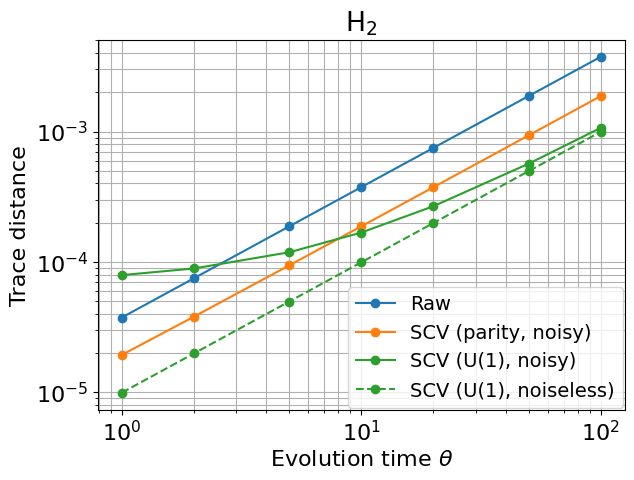

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(layer_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
plt.plot(layer_list, tracedist_SCV_parity_list, marker = 'o', label = 'SCV (parity, noisy)')
plt.plot(layer_list, tracedist_SCV_list, marker = 'o', color = 'tab:green', linestyle = '-', label = 'SCV (U(1), noisy)')
plt.plot(layer_list, tracedist_SCV_noiseless_list, marker = 'o', color = 'tab:green', linestyle = '--', label = 'SCV (U(1), noiseless)')

plt.xscale('log')
plt.yscale('log')
plt.title('H$_2$')
plt.xlabel(r'Evolution time $\theta$')
plt.ylabel('Trace distance')
#plt.xlim(0,22)
#plt.ylim(10**(-3.5),10**(-0.1))
plt.legend(bbox_to_anchor=(1,0),loc='lower right',borderaxespad=0.1, fontsize=14)
plt.grid(which='both', axis='both')
#plt.savefig('H2_U1.pdf', bbox_inches='tight')

In [8]:
n_qubit = 4
layer_list = np.array([1, 2, 5, 10, 20, 50, 100], dtype = 'int')
p_err = 10**(-5)
theta = 2 * np.pi / 100
seed = 12345

tracedist_noisy_list = np.zeros(len(layer_list))
tracedist_SCV_noiseless_list = np.zeros(len(layer_list))
tracedist_SCV_noisy_list = np.zeros(len(layer_list))
tracedist_SCV_flag_list = np.zeros(len(layer_list))
tracedist_SCV_parity_noiseless_list = np.zeros(len(layer_list))
tracedist_SCV_parity_noisy_list = np.zeros(len(layer_list))
tracedist_SCV_parity_flag_list = np.zeros(len(layer_list))


for layer_index, layer in enumerate(layer_list):
    rho_initial = DensityMatrix(n_qubit)
    rho_initial.set_Haar_random_state(seed)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_SCV_noiseless = symmetric_channel_verification_U1(rho_initial, n_qubit, layer, theta, p_err, noise = False, with_ancilla_noise=False)
    rho_SCV_noisy = symmetric_channel_verification_U1(rho_initial, n_qubit, layer, theta, p_err, noise = True, with_ancilla_noise=True)
    rho_SCV_flag = symmetric_channel_verification_U1_flag(rho_initial, n_qubit, layer, theta, p_err, noise = True, with_ancilla_noise=True)
    rho_SCV_parity_noiseless = symmetric_channel_verification_parity(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=False)
    rho_SCV_parity_noisy = symmetric_channel_verification_parity(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=True)
    rho_SCV_parity_flag = symmetric_channel_verification_parity_flag(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=True)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_SCV_noiseless = rho_SCV_noiseless.get_matrix()
    rho_SCV_noisy = rho_SCV_noisy.get_matrix()
    rho_SCV_flag = rho_SCV_flag.get_matrix()
    rho_SCV_parity_noiseless = rho_SCV_parity_noiseless.get_matrix()
    rho_SCV_parity_noisy = rho_SCV_parity_noisy.get_matrix()
    rho_SCV_parity_flag = rho_SCV_parity_flag.get_matrix()

    tracedist_noisy_list[layer_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_SCV_noiseless_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_noiseless / np.trace(rho_SCV_noiseless), ord = 'nuc') / 2
    tracedist_SCV_noisy_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_noisy / np.trace(rho_SCV_noisy), ord = 'nuc') / 2
    tracedist_SCV_flag_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_flag / np.trace(rho_SCV_flag), ord = 'nuc') / 2
    tracedist_SCV_parity_noiseless_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_parity_noiseless / np.trace(rho_SCV_parity_noiseless), ord = 'nuc') / 2
    tracedist_SCV_parity_noisy_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_parity_noisy / np.trace(rho_SCV_parity_noisy), ord = 'nuc') / 2
    tracedist_SCV_parity_flag_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_parity_flag / np.trace(rho_SCV_parity_flag), ord = 'nuc') / 2
    
    print(layer)

1
2
5
10
20
50
100


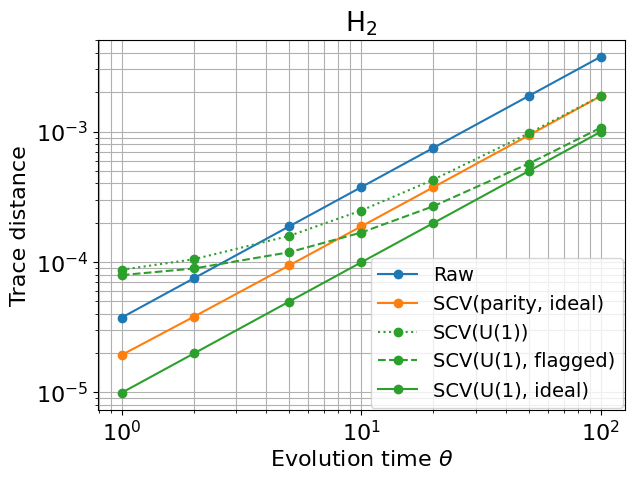

In [15]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(layer_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
#plt.plot(layer_list, tracedist_SCV_parity_noisy_list, marker = 'o', color = 'tab:orange', linestyle = ':', label = 'SCV(parity)')
#plt.plot(layer_list, tracedist_SCV_parity_flag_list, marker = 'o', color = 'tab:orange', linestyle = '--', label = 'SCV(parity, flagged)')
plt.plot(layer_list, tracedist_SCV_parity_noiseless_list, marker = 'o', color = 'tab:orange', linestyle = '-', label = 'SCV(parity, ideal)')
plt.plot(layer_list, tracedist_SCV_noisy_list, marker = 'o', color = 'tab:green', linestyle = ':', label = 'SCV(U(1))')
plt.plot(layer_list, tracedist_SCV_flag_list, marker = 'o', color = 'tab:green', linestyle = '--', label = 'SCV(U(1), flagged)')
plt.plot(layer_list, tracedist_SCV_noiseless_list, marker = 'o', color = 'tab:green', linestyle = '-', label = 'SCV(U(1), ideal)')

plt.xscale('log')
plt.yscale('log')
plt.title('H$_2$')
plt.xlabel(r'Evolution time $\theta$')
plt.ylabel('Trace distance')
#plt.xlim(0,22)
#plt.ylim(10**(-3.5),10**(-0.1))
plt.legend(bbox_to_anchor=(1,0),loc='lower right',borderaxespad=0.1, fontsize=14)
plt.grid(which='both', axis='both')
plt.savefig('H2_U1_flag.pdf', bbox_inches='tight')